# Dataset and Imports
Let's start by importing the packages required and loading the datatset

In [81]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

import statsmodels.api as st
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression as LR
import sklearn.cross_validation as skcv
from pandas_ml import ConfusionMatrix
from sklearn.model_selection import StratifiedKFold

from IPython.display import display, HTML

We use the wine quality data set from UCI Machine Learning Repo. Here we try to model wine quality based on physicochemical tests

In [2]:
winedata=pd.read_csv("winequality-white.csv", sep=";")
winedata.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


(array([   20.,   163.,  1457.,  2198.,   880.,   175.,     5.]),
 array([ 2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 7 Patch objects>)

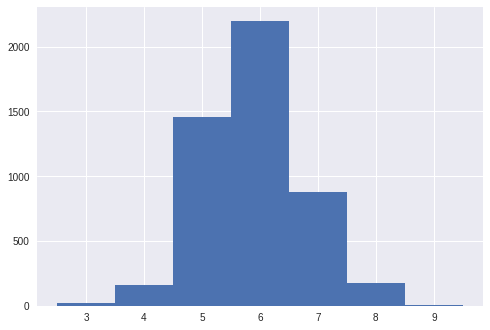

In [3]:
plt.hist(winedata.quality, bins=[2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])

Clearly, wines with quality 3 or 9 is very small. So we try to build model that can predict wines of quality 4 through 8

In [4]:
winedata=winedata[winedata.quality!=9]
winedata=winedata[winedata.quality!=3]

# Exploratory Analysis

Let's start with looking at how the features are distributed

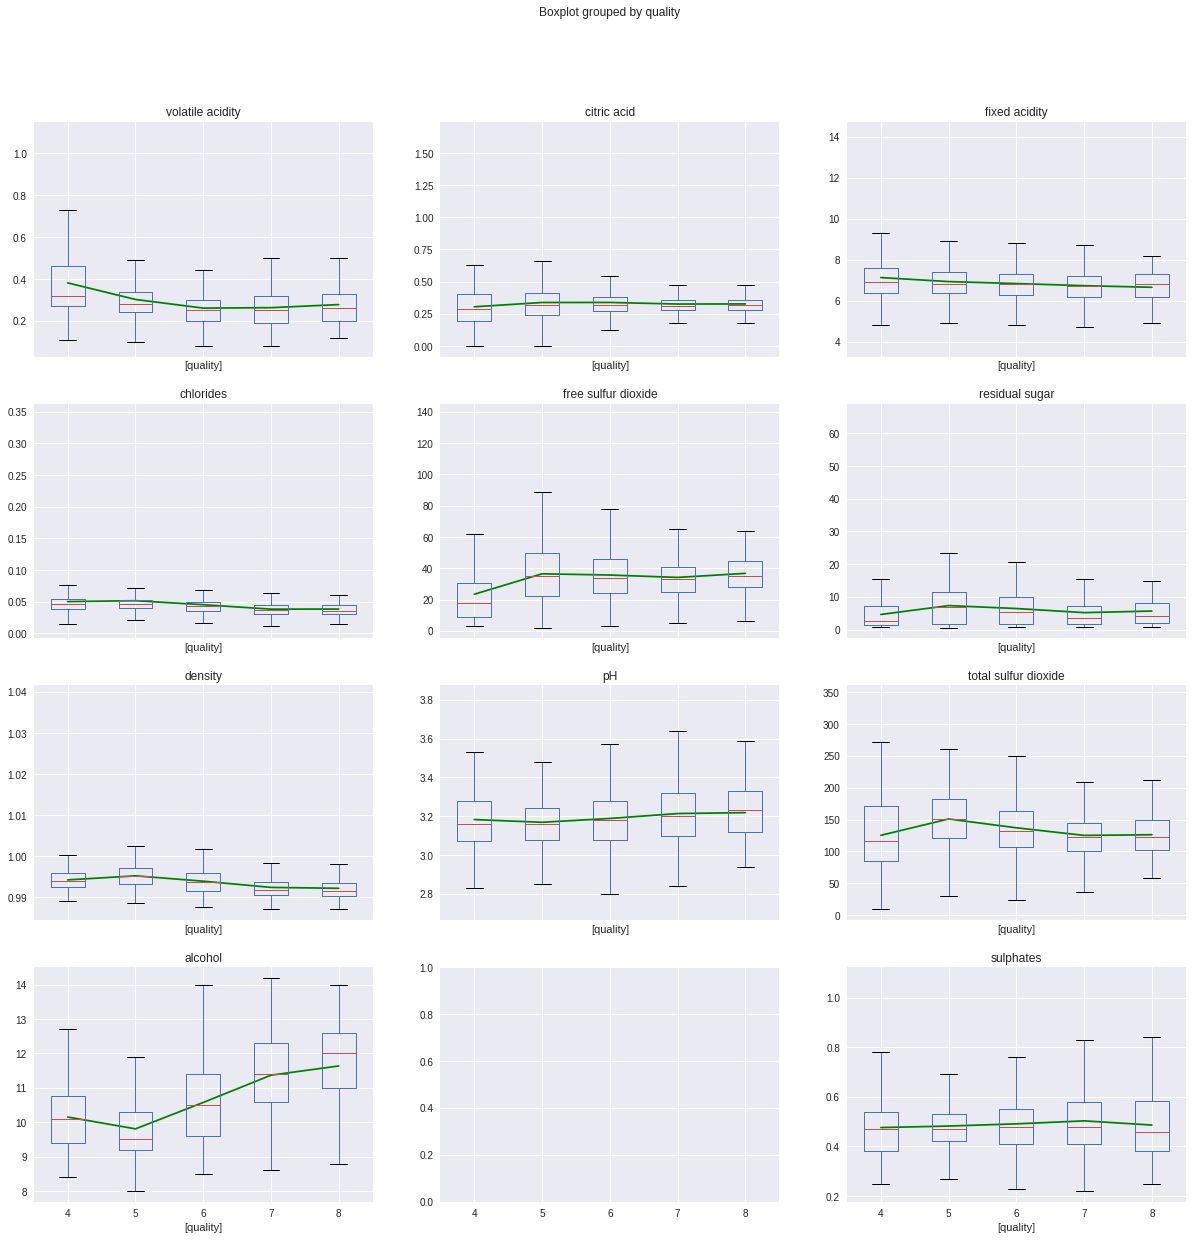

In [5]:
fig,ax=plt.subplots(nrows=4,ncols=3, sharex=True, sharey=False, figsize=(20,20))

for colnum in range(0,winedata.shape[1]-1):
    current_col_data=winedata.ix[:,[colnum,11]]
    mean_frame=current_col_data.groupby("quality").mean().add_suffix('_mean').reset_index()
    curax=ax[colnum/3,(colnum%3)-1]
    curax.plot(mean_frame.ix[:,0]-3,mean_frame.ix[:,1], color="green")
    current_col_data.boxplot(ax=curax,by="quality", figsize=(10,10))

Some observations, 
1. Lesser volatile/fixed acidity seems to indicate the wine being rated higher 
2. Better rated wine tend to have higher pH values, although the increase is very small
3. Better rating corresponds to alcohol
4. Slight dip in chlorides for better rated alcohols

We seek to verify the association and their strengths in the model building phase

Interplay between various features below

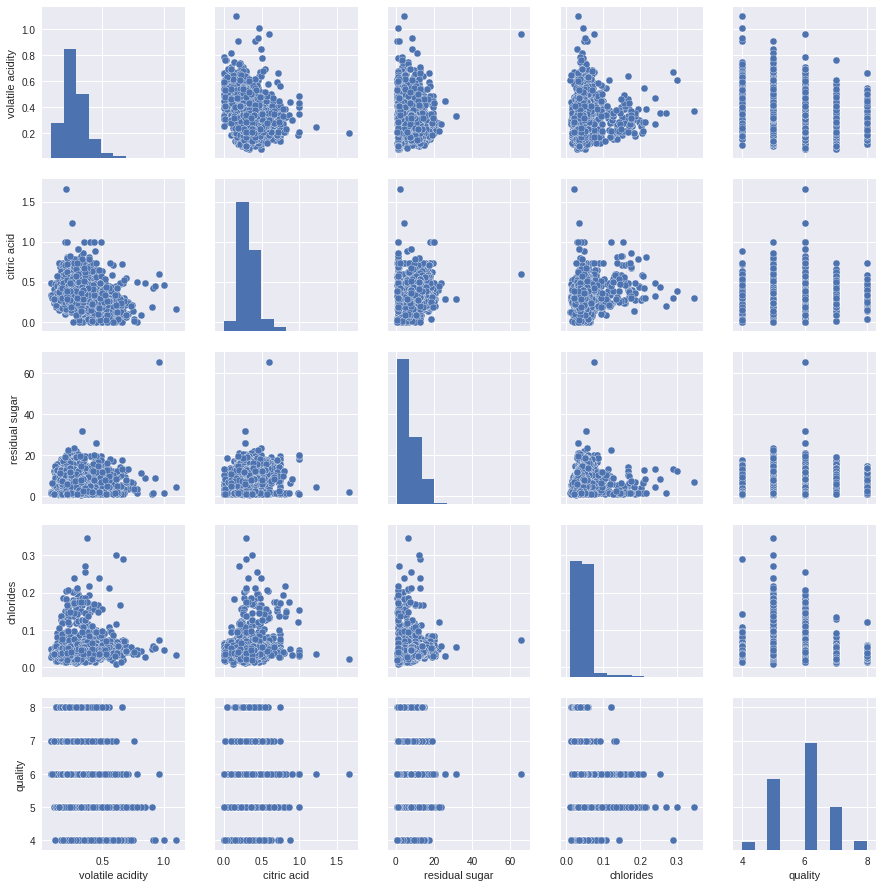

In [6]:
plt.figure(figsize=(10,10))
fig_1=sns.pairplot(winedata.ix[:,[1,2,3,4,11]])
plt.show()

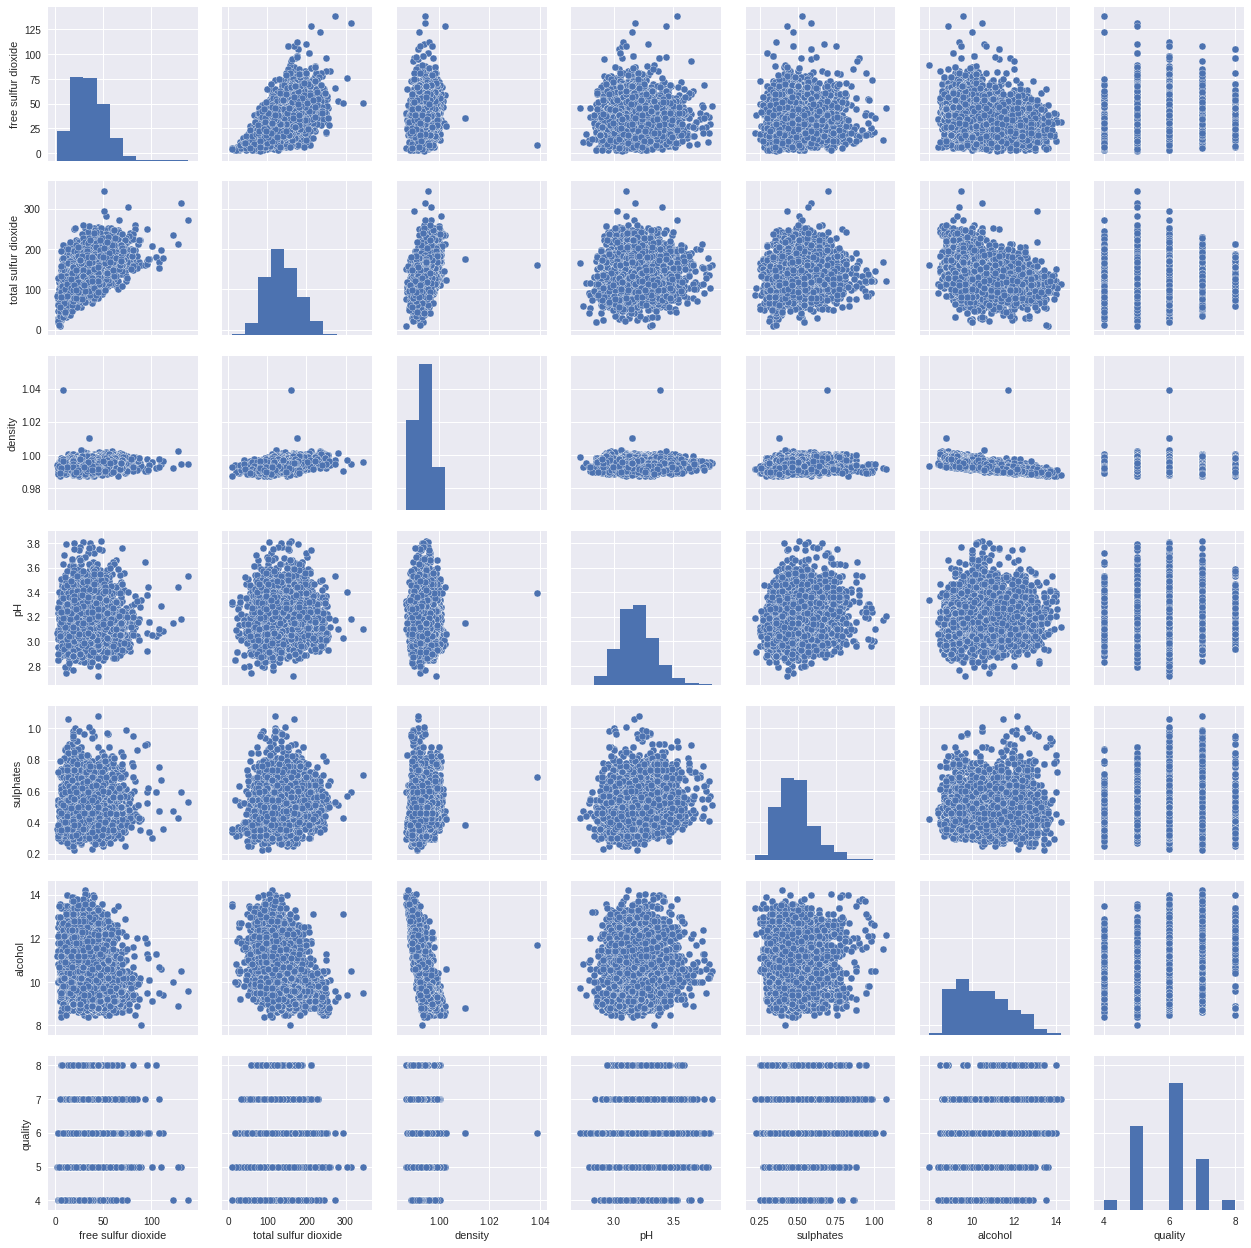

In [7]:
plt.figure(figsize=(10,10))
fig_1=sns.pairplot(winedata.ix[:,5:])
plt.show()

Let's take a look at that rows that have some of the highly irregular values

In [8]:
winedata[(winedata["residual sugar"]> 40) | (winedata["citric acid"]>1) | (winedata.density>1.01)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
745,7.4,0.200,1.66,2.1,0.022,34.0,113.0,0.99165,3.26,0.55,12.2,6
1653,7.9,0.330,0.28,31.6,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
1663,7.9,0.330,0.28,31.6,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
2781,7.8,0.965,0.60,65.8,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6
3152,7.6,0.250,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.1,6


Considering all these have the quality greater than 6, we can test the idea that removing these would give us "better" idea of each factor's influence on the wine's quality being 6

In [9]:
winedata_w_outliers=winedata
winedata=winedata[(winedata["residual sugar"]<= 40) & (winedata["citric acid"]<=1) & (winedata.density<=1.01)]

In [10]:
winedata.shape

(4868, 12)

In [11]:
winedata_w_outliers.shape

(4873, 12)

We ignore qualities 3 and 9, and sample more or less equal number of rows from each 

In [47]:
winedata.reset_index(drop=True, inplace=True)
strats = []
for k in range(4,9):
    dummy_df = winedata[winedata.quality == k]
    if k==4:
        strats.append( dummy_df.sample(163) )
    elif k==8:
        strats.append( dummy_df.sample(175) )
    else:
        strats.append( dummy_df.sample(200) )
subset_winedata=pd.concat(strats)

# Model Building  
## Logistic Model ignoring ordinality 

In [49]:
skf = StratifiedKFold(n_splits=10)
X = subset_winedata[subset_winedata.columns.difference([ "quality"])]
y  = subset_winedata['quality']
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

accuracies=[]
stats_for_analysis=None
model_for_analysis=None
for train_index, test_index in skf.split(X, y):
    
    unstrat_X_train = X.ix[train_index]
    unstrat_X_test= X.ix[test_index]
    unstrat_y_train=y.ix[train_index]
    unstrat_y_test =  y.ix[test_index]
    
    unstrat_X_train.reset_index(drop=True, inplace=True)
    unstrat_X_test.reset_index(drop=True, inplace=True)
    unstrat_y_train.reset_index(drop=True, inplace=True)
    unstrat_y_test.reset_index(drop=True, inplace=True)
    
    unstrat_logr = st.MNLogit(unstrat_y_train,unstrat_X_train)
    unstrat_logr_model = unstrat_logr.fit(disp=0)
    model_for_analysis=unstrat_logr_model.summary()
    unstrat_probs=unstrat_logr_model.predict(unstrat_X_test)
    unstrat_results=unstrat_probs.idxmax(axis=1)+4
#     unstrat_logr= LR()
#     unstrat_logr.fit( unstrat_X_train, unstrat_y_train)
    
#     unstrat_results = unstrat_logr.predict( unstrat_X_test)
    unstrat_cm = ConfusionMatrix(unstrat_y_test.tolist(), unstrat_results)
    prediction_stats=unstrat_cm.stats()
    stats_for_analysis=prediction_stats
    accuracies.append(prediction_stats["overall"]["Accuracy"])
np.mean(accuracies)

0.41686715071825065

First the confusion matrix of one of the folds

In [50]:
stats_for_analysis["cm"]

Predicted   4   5   6   7   8  __all__
Actual                                
4           9   4   1   2   0       16
5           3   9   7   1   0       20
6           2   7   4   7   0       20
7           0   0   5  11   4       20
8           1   0   3   5   8       17
__all__    15  20  20  26  12       93

Typically a decent classifier is expected to have the digonal column to have the highest value among each row. We can see that this fails for quality values 6.  
Next up, accuracy statistics

In [59]:
stats_for_analysis["overall"]

OrderedDict([('Accuracy', 0.4946236559139785),
             ('95% CI', (0.38928546307735046, 0.60031361159147167)),
             ('No Information Rate', 'ToDo'),
             ('P-Value [Acc > NIR]', 2.649434197552049e-05),
             ('Kappa', 0.36523380772582048),
             ("Mcnemar's Test P-Value", 'ToDo')])

We get close to 50% accuracy and kappa score indicates the performance is decent.  
Let's see some model parameters

In [52]:
tbl=model_for_analysis.tables[1]
coeff_table=pd.DataFrame(tbl.data)
tbl

quality=5,coef,std err,z,P>|z|,[0.025,0.975]
alcohol,-0.0045,0.145,-0.031,0.976,-0.289,0.280
chlorides,-0.2815,5.261,-0.054,0.957,-10.592,10.029
citric acid,-0.4610,1.014,-0.455,0.649,-2.449,1.527
density,7.0917,3.979,1.782,0.075,-0.708,14.891
fixed acidity,-0.4269,0.161,-2.654,0.008,-0.742,-0.112
free sulfur dioxide,0.0354,0.011,3.332,0.001,0.015,0.056
pH,-1.2133,0.971,-1.249,0.212,-3.117,0.691
residual sugar,0.0213,0.033,0.650,0.516,-0.043,0.085
sulphates,-1.6316,1.253,-1.302,0.193,-4.087,0.824
total sulfur dioxide,0.0062,0.004,1.560,0.119,-0.002,0.014


Only the following variable are deemed significant

In [53]:
coeff_table=coeff_table.loc[~np.isnan(coeff_table.loc[:,4].convert_objects(convert_numeric=True))]
coeff_table.columns=["var","coef","std err","z","P>|z|","[0.025","0.975]"]
coeff_table.coef=pd.to_numeric(coeff_table.coef)
coeff_table["P>|z|"]=pd.to_numeric(coeff_table["P>|z|"])
fields=coeff_table.loc[coeff_table["P>|z|"] <=0.05,"var"].unique()
fields

array(['fixed acidity', 'free sulfur dioxide', 'volatile acidity',
       'alcohol', 'residual sugar', 'density'], dtype=object)

In [54]:
selected_variables=fields.tolist()

Let's rerun with just these variables

In [55]:
skf = StratifiedKFold(n_splits=10)
X = subset_winedata[selected_variables]
y  = subset_winedata['quality']
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

accuracies=[]
stats_for_analysis=None
model_for_analysis=None
for train_index, test_index in skf.split(X, y):
    
    unstrat_X_train = X.ix[train_index]
    unstrat_X_test= X.ix[test_index]
    unstrat_y_train=y.ix[train_index]
    unstrat_y_test =  y.ix[test_index]
    
    unstrat_X_train.reset_index(drop=True, inplace=True)
    unstrat_X_test.reset_index(drop=True, inplace=True)
    unstrat_y_train.reset_index(drop=True, inplace=True)
    unstrat_y_test.reset_index(drop=True, inplace=True)
    
    unstrat_logr = st.MNLogit(unstrat_y_train,unstrat_X_train)
    unstrat_logr_model = unstrat_logr.fit(disp=0)
    model_for_analysis=unstrat_logr_model.summary()
    unstrat_probs=unstrat_logr_model.predict(unstrat_X_test)
    unstrat_results=unstrat_probs.idxmax(axis=1)+4
#     unstrat_logr= LR()
#     unstrat_logr.fit( unstrat_X_train, unstrat_y_train)
    
#     unstrat_results = unstrat_logr.predict( unstrat_X_test)
    unstrat_cm = ConfusionMatrix(unstrat_y_test.tolist(), unstrat_results)
    prediction_stats=unstrat_cm.stats()
    stats_for_analysis=prediction_stats
    accuracies.append(prediction_stats["overall"]["Accuracy"])
np.mean(accuracies)

0.43596129995544802

In [56]:
stats_for_analysis["cm"]

Predicted   4   5   6   7   8  __all__
Actual                                
4          11   4   1   0   0       16
5           2  10   4   4   0       20
6           2   6   5   7   0       20
7           0   0   5  12   3       20
8           1   0   4   4   8       17
__all__    16  20  19  27  11       93

In [57]:
stats_for_analysis["overall"]

OrderedDict([('Accuracy', 0.4946236559139785),
             ('95% CI', (0.38928546307735046, 0.60031361159147167)),
             ('No Information Rate', 'ToDo'),
             ('P-Value [Acc > NIR]', 2.649434197552049e-05),
             ('Kappa', 0.36523380772582048),
             ("Mcnemar's Test P-Value", 'ToDo')])

Overall, there is not much improvement. We stick with model with less attributes since we want to keep the model simple

In [58]:
model_for_analysis

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                quality   No. Observations:                  845
Model:                        MNLogit   Df Residuals:                      821
Method:                           MLE   Df Model:                           20
Date:                Fri, 26 May 2017   Pseudo R-squ.:                  0.2010
Time:                        16:32:31   Log-Likelihood:                -1084.3
converged:                       True   LL-Null:                       -1357.1
                                        LLR p-value:                8.413e-103
=======================================================================================
          quality=5       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
fixed acidity          -0.3356      0.133     -2.521      0.012      -0.597      -0.075
free sulfur dioxide     0.0420      0.009      4.809      0.000       0.025       0.059
volatile acidity       -2.6394      0.888     -2.972      0.003      -4.380      -0.899
alcohol                -0.0839      0.133     -0.633      0.527      -0.344       0.176
residual sugar          0.0360      0.031      1.165      0.244      -0.025       0.097
density                 2.8866      1.766      1.635      0.102      -0.574       6.347
---------------------------------------------------------------------------------------
          quality=6       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
fixed acidity          -0.4367      0.150     -2.916      0.004      -0.730      -0.143
free sulfur dioxide     0.0502      0.009      5.408      0.000       0.032       0.068
volatile acidity      -10.9428      1.377     -7.949      0.000     -13.641      -8.245
alcohol                 0.9549      0.142      6.738      0.000       0.677       1.233
residual sugar          0.1386      0.034      4.130      0.000       0.073       0.204
density                -5.7240      1.929     -2.967      0.003      -9.505      -1.943
---------------------------------------------------------------------------------------
          quality=7       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
fixed acidity          -0.4704      0.158     -2.982      0.003      -0.779      -0.161
free sulfur dioxide     0.0499      0.010      5.162      0.000       0.031       0.069
volatile acidity      -12.4074      1.473     -8.425      0.000     -15.294      -9.521
alcohol                 1.5697      0.152     10.349      0.000       1.272       1.867
residual sugar          0.1417      0.037      3.867      0.000       0.070       0.214
density               -11.9576      2.048     -5.838      0.000     -15.972      -7.943
---------------------------------------------------------------------------------------
          quality=8       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
fixed acidity          -0.4407      0.166     -2.647      0.008      -0.767      -0.114
free sulfur dioxide     0.0592      0.010      6.006      0.000       0.040       0.078
volatile acidity      -12.0803      1.531     -7.890      0.000     -15.081      -9.079
alcohol                 1.7544      0.158     11.074      0.000       1.444       2.065
residual sugar          0.2032      0.038      5.408      0.000       0.130       0.277
density               -15.1845      2.168     -7.004      0.000     -19.434     -10.935
=========================================================================

### Some observations
1. Across board negative acidity indicates the quality will be less
2. Same is the case for density with small postive effect for quality 5
3. There is a small significant positive effect of alcohol towards quality  
In short, keeping acidity and density down with slight increase in alcohol increases the quality perception of conusmers

## Ordinal Classification Implementation
The overall steps we are going to take are
1. Create "dummy" fields, one for each quality we are considering leving out the last quality (8)
2. Set this dummy field to 1, if the current quality is greater than the quality which the field represents  
    Eg: Row with quality 6 has the following fields (gt_4 =1, gt_5=1, gt_6=0, gt_7=0)
3. Build one regular logistic model for each dummy field. Each of these models will be able to predict the probability of current quality being greater than a quality which the model is built for
4. Use following formula to calculate probability of each quality
    $$Pr(V_{1})  = 1 - Pr(quality > V_{1})$$
    $$Pr(V_{i})  = Pr(quality > V_{i-1}) - Pr(quality > V_{i}), 1 < i < k$$
    $$Pr(V_{k})  =  Pr(quality > V_{k-1})$$
5. Assign the quality which has the highest probability  

### Step 1

In [60]:
subset_winedata["gt_4"]=0
subset_winedata.ix[(subset_winedata.quality>4),'gt_4']=1
subset_winedata["gt_5"]=0
subset_winedata.ix[(subset_winedata.quality>5),'gt_5']=1
subset_winedata["gt_6"]=0
subset_winedata.ix[(subset_winedata.quality>6),'gt_6']=1
subset_winedata["gt_7"]=0
subset_winedata.ix[(subset_winedata.quality>7),'gt_7']=1


In [74]:
skf = StratifiedKFold(n_splits=10)
X = subset_winedata[selected_variables+["gt_4","gt_5","gt_6","gt_7"]]
y  = subset_winedata['quality']
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

accuracies=[]
stats_for_analysis=None
model_for_analysis=None
for train_index, test_index in skf.split(X, y):
    
    unstrat_X_train = X.ix[train_index]
    unstrat_X_test= X.ix[test_index]
    unstrat_y_train=y.ix[train_index]
    unstrat_y_test =  y.ix[test_index]
    
    unstrat_X_train.reset_index(drop=True, inplace=True)
    unstrat_X_test.reset_index(drop=True, inplace=True)
    unstrat_y_train.reset_index(drop=True, inplace=True)
    unstrat_y_test.reset_index(drop=True, inplace=True)
    unstrat_four_model = st.Logit(unstrat_X_train['gt_4'], unstrat_X_train[unstrat_X_train.columns.difference([ "gt_4","gt_5","gt_6","gt_7"])])
    unstrat_four_result = unstrat_four_model.fit(disp=0)
    four_model=unstrat_four_result.summary()
    unstrat_X_test["four_predictions"]=unstrat_four_result.predict(unstrat_X_test[unstrat_X_test.columns.difference([ "gt_4","gt_5","gt_6","gt_7"])])
    unstrat_X_test["pr4"]=1 - unstrat_X_test["four_predictions"]
    
    unstrat_five_model = st.Logit(unstrat_X_train['gt_5'], unstrat_X_train[unstrat_X_train.columns.difference([ "gt_4","gt_5","gt_6","gt_7"])])
    unstrat_five_result = unstrat_five_model.fit(disp=0)
    five_model=unstrat_five_result.summary()
    unstrat_X_test["five_predictions"]=unstrat_five_result.predict(unstrat_X_test[unstrat_X_test.columns.difference([ "gt_4","gt_5","gt_6","gt_7","pr4","four_predictions"])])
    unstrat_X_test["pr5"]= unstrat_X_test["four_predictions"] - unstrat_X_test["five_predictions"]

    unstrat_six_model = st.Logit(unstrat_X_train['gt_6'], unstrat_X_train[unstrat_X_train.columns.difference([ "gt_4","gt_5","gt_6","gt_7"])])
    unstrat_six_result = unstrat_six_model.fit(disp=0)
    six_model=unstrat_six_result.summary()
    unstrat_X_test["six_predictions"]=unstrat_six_result.predict(unstrat_X_test[unstrat_X_test.columns.difference([ "gt_4","gt_5","gt_6","gt_7","pr4","four_predictions","pr5","five_predictions"])])
    unstrat_X_test["pr6"]= unstrat_X_test["five_predictions"] - unstrat_X_test["six_predictions"]

    unstrat_seven_model = st.Logit(unstrat_X_train['gt_7'], unstrat_X_train[unstrat_X_train.columns.difference([ "gt_4","gt_5","gt_6","gt_7"])])
    unstrat_seven_result = unstrat_seven_model.fit(disp=0)
    seven_model=unstrat_seven_result.summary()
    unstrat_X_test["seven_predictions"]=unstrat_seven_result.predict(unstrat_X_test[unstrat_X_test.columns.difference([ "gt_4","gt_5","gt_6","gt_7","pr4","four_predictions","pr5","five_predictions","pr6","six_predictions"])])
    unstrat_X_test["pr7"]= unstrat_X_test["six_predictions"] - unstrat_X_test["seven_predictions"]
    unstrat_X_test["pr8"]= unstrat_X_test["seven_predictions"]
    
    unstrat_X_test["assigned_class_prob"]=unstrat_X_test[["pr4","pr5","pr6","pr7","pr8"]].idxmax(axis=1)
    unstrat_X_test["predicted_quality"]=pd.to_numeric(unstrat_X_test["assigned_class_prob"].str[-1])
    unstrat_cm = ConfusionMatrix(unstrat_y_test.tolist(), unstrat_X_test.predicted_quality.tolist())
    prediction_stats=unstrat_cm.stats()
    stats_for_analysis=prediction_stats
    accuracies.append(prediction_stats["overall"]["Accuracy"])
    sample_X=unstrat_X_test
np.mean(accuracies)

0.41141193753085525

In [75]:
stats_for_analysis["cm"]

Predicted   4   5   6   7   8  __all__
Actual                                
4           8   7   1   0   0       16
5           1  10   7   2   0       20
6           1   7   8   4   0       20
7           0   0   5  12   3       20
8           0   1   4   5   7       17
__all__    10  25  25  23  10       93

In [76]:
stats_for_analysis["overall"]

OrderedDict([('Accuracy', 0.4838709677419355),
             ('95% CI', (0.37893031645428343, 0.58986693701567616)),
             ('No Information Rate', 'ToDo'),
             ('P-Value [Acc > NIR]', 7.8374663809098755e-06),
             ('Kappa', 0.34917626476162705),
             ("Mcnemar's Test P-Value", 'ToDo')])

In [80]:
print(four_model)

                           Logit Regression Results                           
Dep. Variable:                   gt_4   No. Observations:                  845
Model:                          Logit   Df Residuals:                      839
Method:                           MLE   Df Model:                            5
Date:                Fri, 26 May 2017   Pseudo R-squ.:                  0.2709
Time:                        16:59:38   Log-Likelihood:                -284.71
converged:                       True   LL-Null:                       -390.49
                                        LLR p-value:                 9.553e-44
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
alcohol                 0.7217      0.102      7.073      0.000       0.522       0.922
density                -3.3362      1.494     -2.233      0.026      -6.264      -0.408
fixed acidity   

In [77]:
sample_X.iloc[:,10:]

,four_predictions,pr4,five_predictions,pr5,six_predictions,pr6,seven_predictions,pr7,pr8,assigned_class_prob,predicted_quality
0,0.344385,0.655615,0.078398,0.265987,0.061189,0.017209,0.030048,0.031141,0.030048,pr4,4
1,0.629007,0.370993,0.304360,0.324647,0.169685,0.134675,0.062651,0.107034,0.062651,pr4,4
2,0.296512,0.703488,0.028117,0.268395,0.027291,0.000826,0.016754,0.010536,0.016754,pr4,4
3,0.680954,0.319046,0.480025,0.200928,0.247626,0.232400,0.087056,0.160570,0.087056,pr4,4
4,0.908673,0.091327,0.308557,0.600116,0.105296,0.203261,0.059692,0.045604,0.059692,pr5,5
5,0.926111,0.073889,0.415694,0.510417,0.140880,0.274814,0.086375,0.054505,0.086375,pr5,5
6,0.693237,0.306763,0.518177,0.175060,0.249862,0.268314,0.081372,0.168491,0.081372,pr4,4
7,0.794895,0.205105,0.511361,0.283534,0.234522,0.276839,0.081838,0.152684,0.081838,pr5,5
8,0.772029,0.227971,0.441318,0.330711,0.200362,0.240956,0.076302,0.124059,0.076302,pr5,5
9,0.773086,0.226914,0.565104,0.207982,0.327673,0.237431,0.144729,0.182943,0.144729,pr6,6
